# Symbolic Regression
---

Symbolic Regression is a ... THERETICAL EXPLANATION  
[This video](https://www.youtube.com/watch?v=Lo7k9-tP6Fc) is a fantastic explanation of Genetic Programming

In [1]:
import time
import copy as cp
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
##############################################################################
# IMPORT DATA AND WINDOWS
##############################################################################
path_to_data = './windows_ts.h5'

dataset = pd.read_hdf(path_to_data, 'dataset')
sr_trainset = pd.read_hdf(path_to_data, 'trainset')
sr_testset = pd.read_hdf(path_to_data, 'testset')

train_windows = pd.read_hdf(path_to_data, 'train_windows')
test_windows = pd.read_hdf(path_to_data, 'test_windows')
train_windows_sr_inc = pd.read_hdf(path_to_data, 'train_windows_y_inc')
test_windows_sr_inc = pd.read_hdf(path_to_data, 'test_windows_y_inc')

# Bring here the window used
w = 5

In [3]:
##############################################################################
# CREATION OF THE MODEL
##############################################################################        
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

def _xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a    

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
function_set = ['add', 'sub', 'mul', 'div', 'sin', 'log'] #, xexp]
model = SymbolicRegressor(population_size = 1000, tournament_size=5,
                          generations = 25, stopping_criteria=0.00001,
                          function_set = function_set, metric='rmse',
                          p_crossover=0.65, p_subtree_mutation=0.15,
                          p_hoist_mutation=0.05, p_point_mutation=0.1,
                          verbose = 1, random_state = None) #, n_jobs = -1)

In [4]:
##############################################################################
# TRAIN THE NETWORK AND PREDICT - Without previous y
############################################################################## 
# Train
t0 = time.time()
model.fit(train_windows.values[:,:-1], train_windows.values[:,-1])
tF = time.time()

# Predict
sr_y_fit = model.predict(train_windows.values[:,:-1]).reshape(-1,1)
sr_y_pred = model.predict(test_windows.values[:,:-1]).reshape(-1,1)

# Calculating Errors
sr_residuals = sr_y_pred - sr_testset.iloc[5:,-1].values.reshape(-1,1)
sr_rmse = np.sqrt(np.sum(np.power(sr_residuals,2)) / len(sr_residuals))
print('RMSE = %f' % sr_rmse)
print('Time to train %.2f' % (tF - t0))

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.62 145.27926782074658        3 7.942176835734382              N/A      6.42s
   1     9.21 10.815660551045625        4 7.275729589513065              N/A     21.55s
   2     7.87 9.303736777480665        3 6.661544194934035              N/A     25.43s
   3     7.74 9.682183334953052        6 6.66125733923208              N/A     26.49s
   4     7.02 8.97492327977638        5 5.684350049378642              N/A     25.55s
   5     6.61 8.935582089873902        5 5.684350049378642              N/A     24.35s
   6     6.12 8.418393028823063        6 5.547423979760132              N/A     23.10s
   7     5.93 12.257044999773324        5 4.282857295891113              N/A     21.73s
   8     6.46 8.211180821220887        9 3.004535017033524

In [5]:
##############################################################################
# TRAIN THE NETWORK AND PREDICT - With previous y
############################################################################## 
# Train
t0 = time.time()
model.fit(train_windows_sr_inc.values[:,:-1], train_windows_sr_inc.values[:,-1])
tF = time.time()

# Predict
sr_y_fit_inc = model.predict(train_windows_sr_inc.values[:,:-1]).reshape(-1,1)
sr_y_pred_inc = model.predict(test_windows_sr_inc.values[:,:-1]).reshape(-1,1)

# Calculating Errors
sr_residuals_inc = sr_y_pred_inc - sr_testset.iloc[5:,-1].values.reshape(-1,1)
sr_rmse_inc = np.sqrt(np.sum(np.power(sr_residuals_inc,2)) / len(sr_residuals_inc))
print('RMSE = %f' % sr_rmse_inc)
print('Time to train %.2f' % (tF - t0))

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     13.8 2782.2017656175876       12 6.859395425632701              N/A      6.07s
   1    10.57 10.429041316982117        5 6.491119515048631              N/A     23.53s
   2     11.1 10.402732756762742        6 5.010011619975223              N/A     27.65s
   3    12.51 10.938193680170057        6 5.010011619975223              N/A     28.57s
   4    13.29 10.389127153522109       14 4.528616005748179              N/A     29.60s
   5     12.0 10.828061958879603        7 5.100608745826325              N/A     29.49s
   6    12.19 23.384355118393252        7 4.340315286964538              N/A     29.05s
   7    12.29 8.860656378023952        7 4.340315286964538              N/A     28.59s
   8    13.33 9.74951141046398       10 4.3243928512

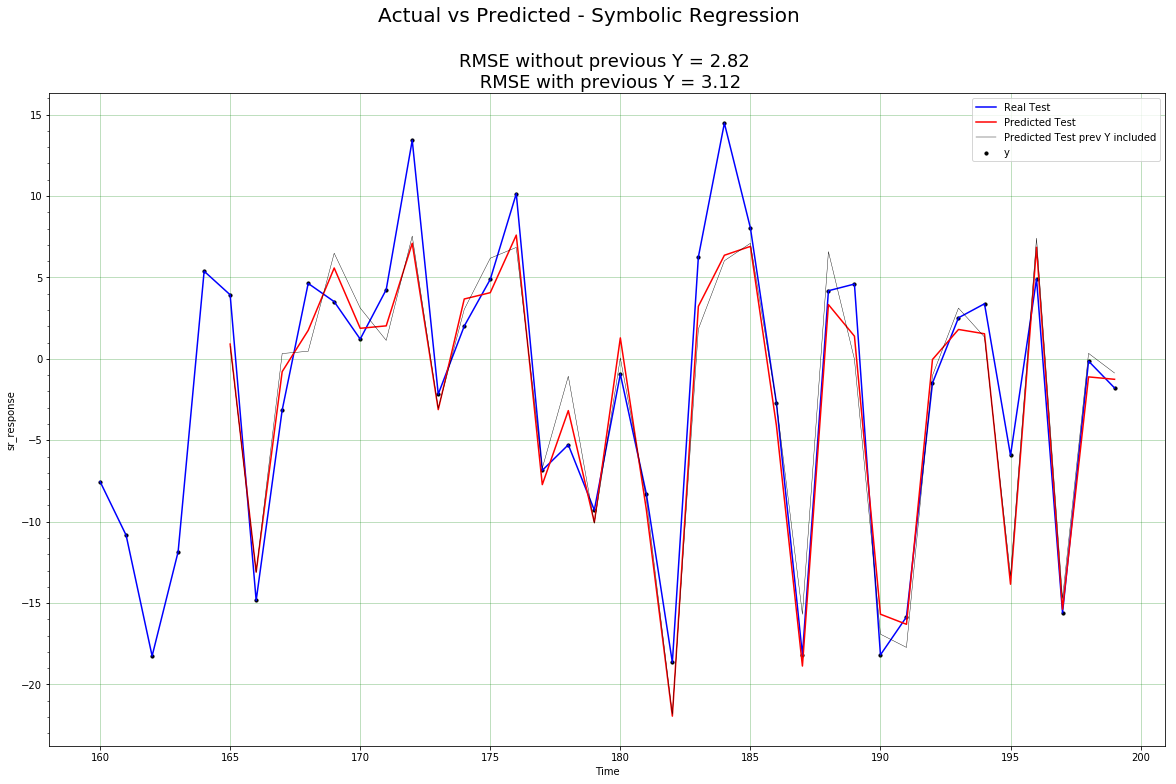

In [6]:
# Plot Predictions
def plot_sr():
    f, ax = plt.subplots(1, figsize=(20,12))
    plt.suptitle('Actual vs Predicted - Symbolic Regression' , fontsize=20)
    plt.title('RMSE without previous Y = %.2f \n RMSE with previous Y = %.2f' 
              % (sr_rmse, sr_rmse_inc), fontsize = 18)
    plt.grid(color='green', linewidth=0.5, alpha=0.5)
    
    plt.scatter(sr_testset.index, sr_testset.y, color='black', s=10)
    plt.plot(sr_testset.index, sr_testset.y, color='b', label='Real Test')
    plt.plot(sr_testset.index[w:], sr_y_pred, color='r', label='Predicted Test')
    plt.plot(sr_testset.index[w:], sr_y_pred_inc, 
             color='k', linewidth=0.4, label='Predicted Test prev Y included')
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    plt.xlabel('Time')
    plt.ylabel('sr_response')
    plt.legend()
    plt.show()

plot_sr()

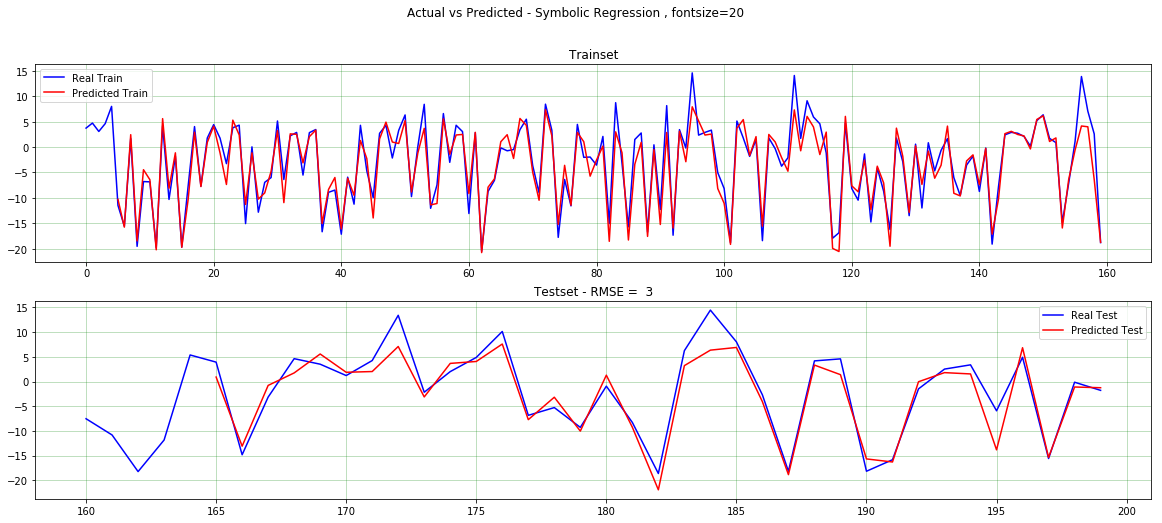

In [7]:
# Complete Plot
f, (ax1, ax2) = plt.subplots(2,1, figsize=(20,8))
plt.suptitle('Actual vs Predicted - Symbolic Regression , fontsize=20')
ax1.grid(color='green', linewidth=0.5, alpha=0.5)
ax2.grid(color='green', linewidth=0.5, alpha=0.5)

ax1.plot(sr_trainset.index, sr_trainset['y'], color='b', label='Real Train')
ax1.plot(sr_trainset.index[w:], sr_y_fit, color='r', label='Predicted Train')
ax1.legend()
ax1.set_title('Trainset')

ax2.plot(sr_testset.index, sr_testset.y, color='b', label='Real Test')
ax2.plot(sr_testset.index[w:], sr_y_pred, color='r', label='Predicted Test')
ax2.set_title('Testset - RMSE = %2.f' % sr_rmse)
ax2.legend()
plt.show()   